CSE 510 - Introduction to Reinforcement Learning 

Instructor: Alina Vereshchaka

#                                        Project 2: Deep Q Network

#### Author: 
Shwetasree Chowdhury


#### Department: 
Computer Science



#### UB Person ID: 
50296995

## Abstract

The goal of the project is to implement Deep Q learning algorithm on some sample Gym AI environments as Pacman, CartPole or MountainCar. The end result of this project is to successfully implement DQN to train our agent to survive in those environments/ solve the problem associated with that environment with maximum reward/score. 

The two environments that we are exploring today are CartPole-v1 and MsPacman-v0. 



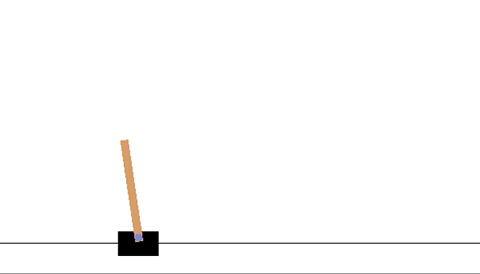                       
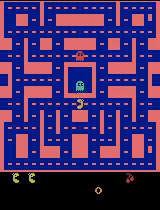


## What is DQN? 

The idea behind DQN was introduced by a paper published in Nature on 26th February 2015, describing a DeepRL system which combines Deep Neural Networks with Reinforcement Learning at scale for the first time, and is able to master a diverse range of Atari 2600 games to superhuman level with only the raw pixels and score as inputs.

The algorithm has been successful in training deep neural networks to show that a novel end-to-end reinforcement learning agent, termed a deep Q-network (DQN), was able to surpass the overall performance of a professional human reference player and all previous agents across a diverse range of 49 game scenarios.

In order to understand how DQN functions, we take reference of Q-Learning - another useful Reinforcement Learning algorithm which takes an action-value function Q(s,a) and decides how favourable an action is to a particular state, using which the decision for the next step is taken. Q learning uses a memory table like structure called a Q-table which stores all possible next action values and decides on which action to take next.



## Why DQN?

Q learning is an efficient algorithm but cannot be expected to work well when the combination of action and states are too large. The necessary computation and memory space required for such a complex environment (for eg, Atari breakout / Space Invaders) would be too high. 

Therefore, in order to address such a need, DQN or Deep Q-Learning was formulated wherein instead of maintaining a Q table with all possible next state values, we approximate a Q value function.

## The DQN Algorithm

* Our aim will be to train a policy that tries to maximize the discounted, cumulative reward 
  Rt0=∑∞t=t0γt−t0rt, where Rt0 is also known as the return. 


* The discount, γ, should be a constant between 0 and 1 that ensures the sum converges. It makes rewards from the uncertain   far future less important for our agent than the ones in the near future that it can be fairly confident about.


* The main idea behind Q-learning is that if we had a function Q∗:State×Action→R, that could tell us what our return would      be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our rewards:                      π∗(s)=argmaxa Q∗(s,a)


* Since neural networks are universal function approximators, we can simply create one and train it to resemble Q∗.


* For our training update rule, we’ll use a fact that every Q function for some policy obeys the Bellman equation:
                          Qπ(s,a)=r+γQπ(s′,π(s′))
      
   The difference between the two sides of the equality is known as the temporal difference error, δ:
                         δ=Q(s,a)−(r+γmaxaQ(s′,a))
 
 
* To minimise this error, we will use the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of Q are very noisy. We calculate this over a batch of transitions, B, sampled from the replay memory.


* DQN uses Epsilon greedy to select the first action at E=1 and reduces over the first few episodes/ frames. At the beginning we uniformly select possible actions but as training progresses, we select the optimal action more frequently.


* Our model will be a convolutional neural network that takes in the difference between the current and previous screen patches. It has two outputs, representing Q(s,left) and Q(s,right) (where s is the input to the network). In effect, the network is trying to predict the expected return of taking each action given the current input.

DQN overcomes unstable learning by mainly 4 techniques.

* Experience Replay 
* Target Network
* Clipping Rewards
* Skipping Frames

## Gym AI environments & Implementation:

A detailed explanation of the gym environments can be found at: https://gym.openai.com/envs/#classic_control

The gym environments used are as follows. Each gym environment used in this project has been aimed to be solved using a DQN learning algorithm by the DQN agent (specified in the implementation part)

## 1. CartPole - v1

* It is a classic control environment where a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 

* The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. 

* A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center as illustrated above.

* This means better performing scenarios will run for longer duration, accumulating larger return.

* The CartPole task is designed so that the inputs to the agent are 4 real values representing the environment state (position, velocity, etc.)

### Implementation using Keras

#### 1. importing necessary libraries

Keras is an open-source neural-network library written in Python for fast experimentation with deep neural networks

In [6]:
import random
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import pandas as pd


#### 2. Generating a sample CartPole Environment

In [7]:
env= gym.make("CartPole-v1")
print (env.action_space)
observation = env.reset()
while True:
    env.render()
    action=env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break;
env.close()

Discrete(2)


#### 3. Creating a DQNAgent

In [8]:
class CartPole_Agent:
    def __init__(self, state_size, action_size):
        # Define environment parameters
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        
        # Define Hyperparameters to learn through deep learning
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate to start
        self.epsilon_min = 0.01 # minimum exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.995  # decay rate for epsilon
        self.learning_rate = 0.001 # steps needed until target network gets updated
        
        #Construct DQN Model
        self.model = self._build_model()

    
    #Build Neural Network model for DQN
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential() #Sequential placement of Networks
        
       # The DL model has 3 layers with final layer having output size as the number of possible actions
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate)) #defining MSE loss
        return model

    #Function to save past experiences as replays
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Function to select actions based on epsilon-greedy method
    def act(self, state):
        if np.random.rand() <= self.epsilon: #Explore randomly
            return random.randrange(self.action_size)
        #Generate probability of using each random action
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # Returns action using policy

    # Randomly select some actions and train the agent from previous replay experiences
    def replay(self, batch_size): 
    # perform replay on a small batch of the stored experiences 
        minibatch = random.sample(self.memory, batch_size)
        
        # checking if the agent has reached target
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            
            # Making new targets
            # Output the Q-value predictions 
            target_f = self.model.predict(state)
            
    # Update the chosen action value with the new computed target            
            target_f[0][action] = target
        
        # Train the new model based on the new target and current state
        # for next possible action
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
# decay the epsilon every time it grows larger than the minimum epsilon                        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#load a saved model
    def load(self, name):
        self.model.load_weights(name)

#save parameters of trained models
    def save(self, name):
        self.model.save_weights(name)




#### 4. Defining the parameters and associated Parameters

In [9]:
# if __name__ == "__main__":
env = gym.make("CartPole-v1")
EPISODES = 175 
rewards_over_episodes= []
epsilon_over_episodes= []
time_over_episodes=[]

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

done = False #Initial state of problem set to false
batch_size = 32 # we use 32 elements as the sampling size for a batch


#### 5. Training the agent

episode: 1/175, score: 21, e: 1.0
episode: 2/175, score: 22, e: 0.94
episode: 3/175, score: 43, e: 0.76
episode: 4/175, score: 18, e: 0.69
episode: 5/175, score: 19, e: 0.63
episode: 6/175, score: 12, e: 0.59
episode: 7/175, score: 21, e: 0.53
episode: 8/175, score: 14, e: 0.5
episode: 9/175, score: 13, e: 0.47
episode: 10/175, score: 19, e: 0.42
episode: 11/175, score: 27, e: 0.37
episode: 12/175, score: 31, e: 0.32
episode: 13/175, score: 35, e: 0.27
episode: 14/175, score: 53, e: 0.2
episode: 15/175, score: 35, e: 0.17
episode: 16/175, score: 31, e: 0.15
episode: 17/175, score: 101, e: 0.088
episode: 18/175, score: 86, e: 0.057
episode: 19/175, score: 66, e: 0.041
episode: 20/175, score: 96, e: 0.025
episode: 21/175, score: 72, e: 0.018
episode: 22/175, score: 129, e: 0.01
episode: 23/175, score: 102, e: 0.01
episode: 24/175, score: 98, e: 0.01
episode: 25/175, score: 125, e: 0.01
episode: 26/175, score: 131, e: 0.01
episode: 27/175, score: 202, e: 0.01
episode: 28/175, score: 149, 

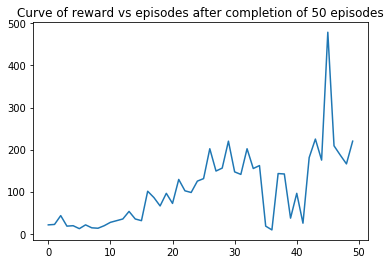

episode: 51/175, score: 208, e: 0.01
episode: 52/175, score: 204, e: 0.01
episode: 53/175, score: 281, e: 0.01
episode: 54/175, score: 269, e: 0.01
episode: 55/175, score: 209, e: 0.01
episode: 56/175, score: 314, e: 0.01
episode: 57/175, score: 499, e: 0.01
episode: 58/175, score: 167, e: 0.01
episode: 59/175, score: 181, e: 0.01
episode: 60/175, score: 25, e: 0.01
episode: 61/175, score: 182, e: 0.01
episode: 62/175, score: 341, e: 0.01
episode: 63/175, score: 286, e: 0.01
episode: 64/175, score: 129, e: 0.01
episode: 65/175, score: 210, e: 0.01
episode: 66/175, score: 143, e: 0.01
episode: 67/175, score: 292, e: 0.01
episode: 68/175, score: 164, e: 0.01
episode: 69/175, score: 146, e: 0.01
episode: 70/175, score: 252, e: 0.01
episode: 71/175, score: 37, e: 0.01
episode: 72/175, score: 243, e: 0.01
episode: 73/175, score: 185, e: 0.01
episode: 74/175, score: 317, e: 0.01
episode: 75/175, score: 206, e: 0.01
episode: 76/175, score: 486, e: 0.01
episode: 77/175, score: 198, e: 0.01
epi

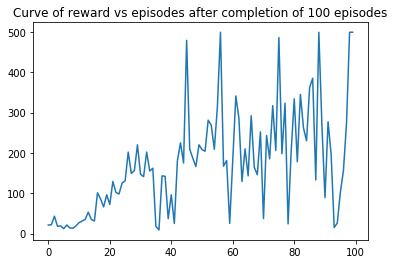

episode: 101/175, score: 369, e: 0.01
episode: 102/175, score: 184, e: 0.01
episode: 103/175, score: 270, e: 0.01
episode: 104/175, score: 176, e: 0.01
episode: 105/175, score: 182, e: 0.01
episode: 106/175, score: 71, e: 0.01
episode: 107/175, score: 223, e: 0.01
episode: 108/175, score: 227, e: 0.01
episode: 109/175, score: 250, e: 0.01
episode: 110/175, score: 9, e: 0.01
episode: 111/175, score: 23, e: 0.01
episode: 112/175, score: 10, e: 0.01
episode: 113/175, score: 201, e: 0.01
episode: 114/175, score: 499, e: 0.01
episode: 115/175, score: 65, e: 0.01
episode: 116/175, score: 145, e: 0.01
episode: 117/175, score: 165, e: 0.01
episode: 118/175, score: 328, e: 0.01
episode: 119/175, score: 154, e: 0.01
episode: 120/175, score: 499, e: 0.01
episode: 121/175, score: 187, e: 0.01
episode: 122/175, score: 499, e: 0.01
episode: 123/175, score: 95, e: 0.01
episode: 124/175, score: 207, e: 0.01
episode: 125/175, score: 88, e: 0.01
episode: 126/175, score: 499, e: 0.01
episode: 127/175, sc

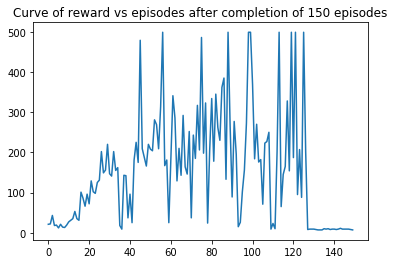

episode: 151/175, score: 8, e: 0.01
episode: 152/175, score: 7, e: 0.01
episode: 153/175, score: 8, e: 0.01
episode: 154/175, score: 8, e: 0.01
episode: 155/175, score: 7, e: 0.01
episode: 156/175, score: 8, e: 0.01
episode: 157/175, score: 15, e: 0.01
episode: 158/175, score: 8, e: 0.01
episode: 159/175, score: 7, e: 0.01
episode: 160/175, score: 8, e: 0.01
episode: 161/175, score: 9, e: 0.01
episode: 162/175, score: 7, e: 0.01
episode: 163/175, score: 8, e: 0.01
episode: 164/175, score: 150, e: 0.01
episode: 165/175, score: 499, e: 0.01
episode: 166/175, score: 499, e: 0.01
episode: 167/175, score: 394, e: 0.01
episode: 168/175, score: 499, e: 0.01
episode: 169/175, score: 220, e: 0.01
episode: 170/175, score: 271, e: 0.01
episode: 171/175, score: 101, e: 0.01
episode: 172/175, score: 282, e: 0.01
episode: 173/175, score: 251, e: 0.01
episode: 174/175, score: 307, e: 0.01
episode: 175/175, score: 271, e: 0.01


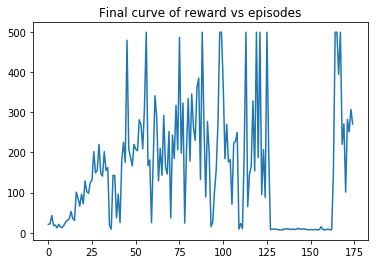

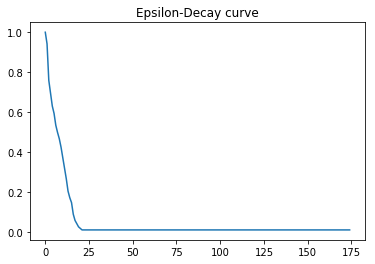

In [10]:
for e in range(EPISODES):
    r_Track = 0 # keep track of rewards for every episode over time

# Reset environment before each episode runs
    state = env.reset()
    state = np.reshape(state, [1, state_size]) # converting state to a computable dimension

  #run episode for a max score or time of 1000 units  
    for time in range(1000):
        env.render()

        # Perform interaction of the agent with the environment 
    # to get the dynamics and steps to take            
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)

    # get the reward if target is reached,
    # else, keep discounting the reward every time
        reward = reward if not done else -10
        next_state = np.reshape(next_state, [1, state_size])

        # Store replay memory
        agent.remember(state, action, reward, next_state, done)
        state = next_state

        #if episode ends, print score, episode number and epsilon value
        if done:                
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e+1, EPISODES, time, agent.epsilon))
            break
        # collect all rewards for each episode    
        r_Track += reward    

        # if agent learns more than the batch size, send it the stored
    # replay experiences of that batch size
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    # save epsilon and reward values for each episode        
    epsilon_over_episodes.append(agent.epsilon)
    rewards_over_episodes.append(r_Track)

    # Plot curve of reward vs episode for every 100 episodes
    if (e+1) % 50 == 0:
        plt.figure()
        plt.title('Curve of reward vs episodes after completion of ' + str(e+1) + ' episodes')
        plt.plot(rewards_over_episodes)
        plt.show()

#Plot reward or score v/s episode
plt.figure()
plt.title('Final curve of reward vs episodes')
plt.plot(rewards_over_episodes)
plt.show()


#plot Epsilon Decay Curve
plt.figure()
plt.title('Epsilon-Decay curve')
plt.plot(epsilon_over_episodes)
env.close()


### Conclusion

* The CartPole environment trains rapidly over a series of 100+ episodes. The agent gradually starts with exploration at epsilon =1 and gradually decreases, implying transition from exploration to exploitation (implied by the epsilon decay curve)

* The reward v/s episode graph shows how the agent gradually learns and improves its performance and has a gradual high mean performance towards the middle/ end of the performance.

* In order to stabilize the neural network environment, most algorithms use a target network implementation. However, I felt ( over a couple of times that I ran the episodes) that I was able to obtain the desired result even without the implementation of a target network. 

## 2. MsPacman - v0

* In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3) 
* Each action is repeatedly performed for a duration of kk frames, where kk is uniformly sampled from \{2, 3, 4\}{2,3,4}.

There are 250 pellets that can be eaten by Ms Pacman. Neural Networks are very good at learning large number of features for highly structured data. Hence, we can use the idea of Q-learning where the Q-function will be represented by a neural network with states and actions as the inputs and returns Q-values as the outputs. 

To make the agent learn to play the game on its own, we feed it to a Deep Learning model, thereby using DQN to estimate best Q-values for the agent in its environment. Thus, in the DQN, we have 4 quantities - state (s), action (a), reward (r), next state (s'). So, our Q-table would be generated using the following idea - 

* Use forward propagation to predict Q-values for current state s and all actions a.

* Generate the maximum overall networks $Q_{max}(s,a)$ for the next state s.

* Generate Q-values for target action using the following formula - 

$$ y(s,a) = r + \gamma.max_{a'} Q_{target}(s', a')$$

### Implementation using keras

#### 1. Importing necessary libraries

In [2]:
import gym
import time
import numpy as np
import random
from collections import deque
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd



Using TensorFlow backend.


#### 2. Generating a sample Ms Pacman Environment

In [3]:
env= gym.make("MsPacman-v0")
print (env.action_space)
observation = env.reset()
while True:
    env.render()
    action=env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break;
env.close()

Discrete(9)


#### 3. Creating a DQN Pacman Agent

In [4]:
class Pacman_Agent:
    def __init__(self, state_size, action_size):
        # Define environment parameters
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        
        # Define Hyperparameters to learn through deep learning
        self.gamma = 0.95            # discount rate
        self.epsilon = 1.0          # exploration rate to start
        self.epsilon_min = 0.1      # minimum exploration rate (epsilon-greedy)
        self.epsilon_decay = 0.995  # decay rate for epsilon
        self.learning_rate = 0.001
        self.update_rate = 1000     # steps needed until target network gets updated
        
        # Construct DQN models
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        self.model.summary()

    # Build the CNN for DQN on the pacman environment 
    def _build_model(self):
        model = Sequential()
        
        # Defining the Conv Layers - EXTRACTING FEATURES FROM ENVIRONMENT
        # 1st layer - output size = 32 nodes, kernel size = 8x8, skipping steps (strides) = 4 pixels,
        # input_size = initial state size of the environment
        model.add(Conv2D(32, (8, 8), strides=4, padding='same', input_shape=self.state_size))
        model.add(Activation('relu'))
        
        #2nd layer - output size = 64 nodes, kernel size = 4x4, strides reduced to 2 pixels
        model.add(Conv2D(64, (4, 4), strides=2, padding='same'))
        model.add(Activation('relu'))
        
        #3rd layer - output size = 64 nodes, kernel size = 3x3, strides reduced to 1 pixel
        model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(Flatten())

        # Defining the Fully Connected Neural Nets to classify features
        # 1st layer - input size = 512 nodes, 2nd layer - output size = number of possible actions of the agent
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        
        #generate model
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    #Function to save past experiences as replays
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Function to select actions based on epsilon-greedy method
    def act(self, state):
        # Explore randomly
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        #Generate probability of using each random action
        actions = self.model.predict(state)
        return np.argmax(actions[0])  # Returns action using policy

    # Randomly select some actions and train the agent from previos replay experiences 
    def replay(self, batch_size):
        # perform replay on a small batch of the stored experiences 
        minibatch = random.sample(self.memory, batch_size)
        
        # checking if the agent has reached target
        for state, action, reward, next_state, done in minibatch:
            if not done:
                target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)))
            else:
                target = reward
                
            # Making new targets
            # Output the Q-value predictions
            target_f = self.model.predict(state)
            
            # Update the chosen action value with the new computed target
            target_f[0][action] = target
            
            # Train the new model based on the new target and current state
            # for next possible action
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        # decay the epsilon every time it grows larger than the minimum epsilon 
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    #Update the target model based on the current computed values
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
            
    #load a saved model
    def load(self, name):
        self.model.load_weights(name)
    
    #save parameters of trained models
    def save(self, name):
        self.model.save_weights(name)

#### 4. Defining a function that divides an image into 4 frames

In [5]:
# Function that helps in joining 4 images together after training
# and returns an average of the combined images
def join_images(images, state_size = (88, 80, 1)):
    new_dim_Arr = np.zeros((state_size), np.float64)
    avg_image = np.expand_dims(new_dim_Arr, axis=0)

    for img in images:
        avg_image += img
        
    if len(images) < 4:
        return avg_image / len(images)
    else:
        return avg_image / 4

#### 5. Preprocessing the Pacman environment for feeding to the Neural Network

Each state for the Pacman environment is basically a frame of the game screen which is stored as a numpy array - 3D as an RGB image of the screen. 

Feeding a 3D array to the NN is difficult to train and highly computationally expensive. Hence, we do the basic preprocessing as follows - 

* Scale down the image / frame down to 88 x 80 grid size.
* Next, we convert the RGB image to the greyscale and 
* Generate the contrasted image for sharper pixels

We develop our Deep Learning Model as a Convolutional Neural Network with the following specifications - 

* 3 convolutional layers
    * 1st layer - 32 nodes, 8x8 convolution mask, strides = 4, downsized to shape = 22x20x32, relu
    * 2nd layer - 64 nodes, 4x4 convolution mask, strides = 2, downsized to shape = 11x10x64, relu
    * 3rd layer - 64 nodes, 3x3 convolution mask, strides = 1, downsized to shape = 11x10x64, relu
    
* 2 fully connected layers
    * 1st layer = 512 nodes, relu, shape = 11x10x64
    * 2nd and final layer = 9 nodes for 9 different possible actions
    
Apart from the normal agent's DQN, we also need to maintain another Deep learning model for the target. So, we define a DQN model for the target as well, which estimates the next state's Q-values for each possible action to compute the target Q-values for training the agent DQN. 

In [6]:
# Function for preprocessing each frame, src: github.com/ageron/tiny-dqn
def process_frame(frame, state_size = (88, 80, 1)):
    pacman = np.array([210, 164, 74]).mean()
    img = frame[1:176:2, ::2]    # Crop and downsize
    img = img.mean(axis=2)       # Convert to greyscale
    img[ img==pacman ] = 0 # Improve contrast by making pacman white
    # Normalize each image between -1 and 1.
    img = img/128
    new_dim_img = img.reshape(state_size)
    
    return np.expand_dims(new_dim_img, axis=0)

#### 6. Defining the environment, action size and state size

In [7]:
env = gym.make('MsPacman-v0')
state_size = (88, 80, 1)
action_size = env.action_space.n
agent = Pacman_Agent(state_size, action_size)

EPISODES = 50
batch_size = 8 # we use 8 elements in a batch at a time for Pacman

# wait for 90 actions before an episode begins
skips = 90  

total_time = 0   # keeping track of total number of steps taken
all_rewards = 0  # Used to compute avg reward over time

#initial done report = False
done = False

rewards_over_episodes= []
eps_over_episodes= []
score_over_episodes = []

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 22, 20, 32)        2080      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 10, 64)        32832     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 10, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 11, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7040)              0         
__________

#### 7. Training the Pacman Agent

episode: 1/50, game score: 480.0, reward: -297.0, avg reward: 480.0, time: 776, epsilon: 0.0996820918179746
episode: 2/50, game score: 510.0, reward: -73.0, avg reward: 495.0, time: 582, epsilon: 0.0996820918179746
episode: 3/50, game score: 320.0, reward: -83.0, avg reward: 436.6666666666667, time: 402, epsilon: 0.0996820918179746
episode: 4/50, game score: 260.0, reward: -182.0, avg reward: 392.5, time: 441, epsilon: 0.0996820918179746
episode: 5/50, game score: 390.0, reward: -380.0, avg reward: 392.0, time: 769, epsilon: 0.0996820918179746
episode: 6/50, game score: 360.0, reward: -493.0, avg reward: 386.6666666666667, time: 852, epsilon: 0.0996820918179746
episode: 7/50, game score: 920.0, reward: 30.0, avg reward: 462.85714285714283, time: 889, epsilon: 0.0996820918179746
episode: 8/50, game score: 290.0, reward: -94.0, avg reward: 441.25, time: 383, epsilon: 0.0996820918179746
episode: 9/50, game score: 240.0, reward: -89.0, avg reward: 418.8888888888889, time: 328, epsilon: 0.0

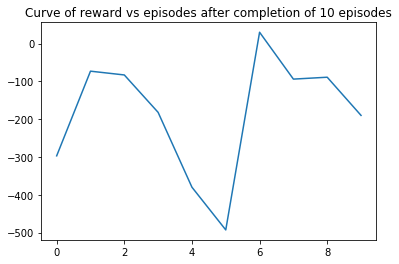

episode: 11/50, game score: 660.0, reward: -62.0, avg reward: 428.1818181818182, time: 721, epsilon: 0.0996820918179746
episode: 12/50, game score: 330.0, reward: -138.0, avg reward: 420.0, time: 467, epsilon: 0.0996820918179746
episode: 13/50, game score: 370.0, reward: -209.0, avg reward: 416.15384615384613, time: 578, epsilon: 0.0996820918179746
episode: 14/50, game score: 280.0, reward: -163.0, avg reward: 406.42857142857144, time: 442, epsilon: 0.0996820918179746
episode: 15/50, game score: 440.0, reward: -181.0, avg reward: 408.6666666666667, time: 620, epsilon: 0.0996820918179746
episode: 16/50, game score: 530.0, reward: -42.0, avg reward: 416.25, time: 571, epsilon: 0.0996820918179746
episode: 17/50, game score: 430.0, reward: -182.0, avg reward: 417.05882352941177, time: 611, epsilon: 0.0996820918179746
episode: 18/50, game score: 250.0, reward: -100.0, avg reward: 407.77777777777777, time: 349, epsilon: 0.0996820918179746
episode: 19/50, game score: 580.0, reward: -164.0, av

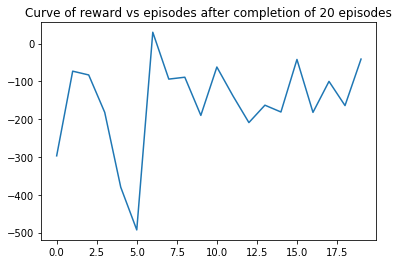

episode: 21/50, game score: 410.0, reward: -191.0, avg reward: 420.0, time: 600, epsilon: 0.0996820918179746
episode: 22/50, game score: 370.0, reward: -332.0, avg reward: 417.72727272727275, time: 701, epsilon: 0.0996820918179746
episode: 23/50, game score: 1030.0, reward: 366.0, avg reward: 444.3478260869565, time: 663, epsilon: 0.0996820918179746
episode: 24/50, game score: 310.0, reward: -113.0, avg reward: 438.75, time: 422, epsilon: 0.0996820918179746
episode: 25/50, game score: 350.0, reward: -200.0, avg reward: 435.2, time: 549, epsilon: 0.0996820918179746
episode: 26/50, game score: 590.0, reward: -293.0, avg reward: 441.15384615384613, time: 882, epsilon: 0.0996820918179746
episode: 27/50, game score: 340.0, reward: -243.0, avg reward: 437.4074074074074, time: 582, epsilon: 0.0996820918179746
episode: 28/50, game score: 250.0, reward: -122.0, avg reward: 430.7142857142857, time: 371, epsilon: 0.0996820918179746
episode: 29/50, game score: 240.0, reward: -192.0, avg reward: 42

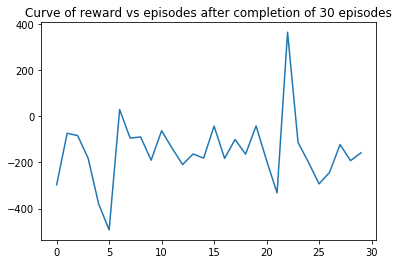

episode: 31/50, game score: 590.0, reward: -206.0, avg reward: 422.5806451612903, time: 795, epsilon: 0.0996820918179746
episode: 32/50, game score: 230.0, reward: -113.0, avg reward: 416.5625, time: 342, epsilon: 0.0996820918179746
episode: 33/50, game score: 380.0, reward: -201.0, avg reward: 415.45454545454544, time: 580, epsilon: 0.0996820918179746
episode: 34/50, game score: 350.0, reward: -145.0, avg reward: 413.52941176470586, time: 494, epsilon: 0.0996820918179746
episode: 35/50, game score: 340.0, reward: -540.0, avg reward: 411.42857142857144, time: 879, epsilon: 0.0996820918179746
episode: 36/50, game score: 1130.0, reward: 407.0, avg reward: 431.3888888888889, time: 722, epsilon: 0.0996820918179746
episode: 37/50, game score: 680.0, reward: -133.0, avg reward: 438.1081081081081, time: 812, epsilon: 0.0996820918179746
episode: 38/50, game score: 310.0, reward: -57.0, avg reward: 434.7368421052632, time: 366, epsilon: 0.0996820918179746
episode: 39/50, game score: 380.0, rewa

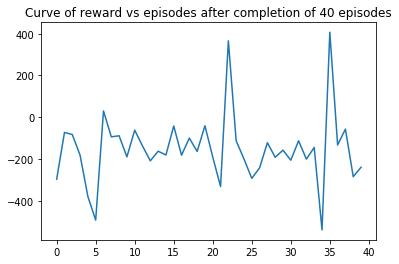

episode: 41/50, game score: 690.0, reward: -168.0, avg reward: 439.5121951219512, time: 857, epsilon: 0.0996820918179746
episode: 42/50, game score: 400.0, reward: -31.0, avg reward: 438.57142857142856, time: 430, epsilon: 0.0996820918179746
episode: 43/50, game score: 350.0, reward: -238.0, avg reward: 436.51162790697674, time: 587, epsilon: 0.0996820918179746
episode: 44/50, game score: 280.0, reward: -459.0, avg reward: 432.95454545454544, time: 738, epsilon: 0.0996820918179746
episode: 45/50, game score: 920.0, reward: -547.0, avg reward: 443.77777777777777, time: 1466, epsilon: 0.0996820918179746
episode: 46/50, game score: 320.0, reward: -81.0, avg reward: 441.0869565217391, time: 400, epsilon: 0.0996820918179746
episode: 47/50, game score: 580.0, reward: -241.0, avg reward: 444.0425531914894, time: 820, epsilon: 0.0996820918179746
episode: 48/50, game score: 390.0, reward: -119.0, avg reward: 442.9166666666667, time: 508, epsilon: 0.0996820918179746
episode: 49/50, game score: 1

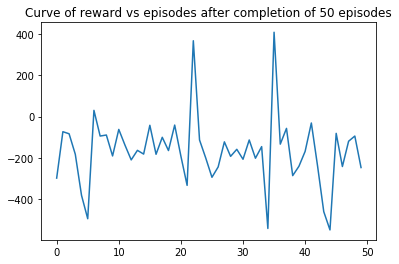

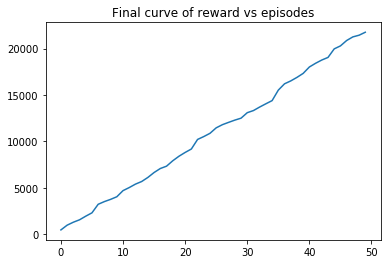

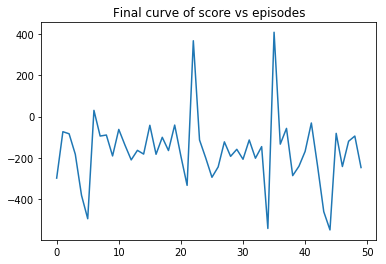

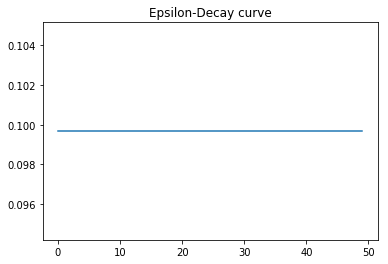

In [8]:
for ep in range(EPISODES):
    total_reward = 0
    score= 0
    
    # Reset environment for every episode, preprocess it and blend 4 images together in every episode
    state = process_frame(env.reset())
    images = deque(maxlen=4)  
    images.append(state)
    
    # skip actions before start of each episode
    for _ in range(skips): 
        env.step(0)
    
    # run each episode for a certain time limit
    for time in range(10000):
        env.render()
        total_time += 1
        
        # Every update_rate timesteps we update the target network parameters
        if total_time % agent.update_rate == 0:
            agent.update_target_model()
        
        # Return the avg of the last 4 frames
        state = join_images(images)
        
        # Perform interaction of the agent with the environment 
        # to get the dynamics and steps to take
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        
        # Return the avg of the last 4 frames after processing and
        # combining the images
        next_state = process_frame(next_state)
        images.append(next_state)
        next_state = join_images(images)
        
        # Store replay memory
        agent.remember(state, action, reward, next_state, done)
        
        #Update the state
        state = next_state
        
        # Add the reward
        score+= reward
        
        reward -= 1  # Discount to avoid collection of rewards
        total_reward += reward
        
        if done:
            all_rewards += score
            
            print("episode: {}/{}, game score: {}, reward: {}, avg reward: {}, time: {}, epsilon: {}"
                  .format(ep+1, EPISODES, score, total_reward, all_rewards/(ep+1), time, agent.epsilon))
            
            break
        
        # if agent learns more than the batch size, send it the stored
        # replay experiences of that batch size
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
        
    # save epsilon and reward values for each episode
    eps_over_episodes.append(agent.epsilon)
    rewards_over_episodes.append(total_reward)
    score_over_episodes.append(all_rewards)
    
    # Plot curve of reward vs episode after every 100 episodes
    if (ep+1) % 10 == 0:
        plt.figure()
        plt.title('Curve of reward vs episodes after completion of ' + str(ep+1) + ' episodes')
        plt.plot(rewards_over_episodes)
        plt.show()

# plot epsilon and reward curves at the end of the episodes        
plt.figure()
plt.title('Final curve of reward vs episodes')
plt.plot(score_over_episodes)
plt.show()

plt.figure()
plt.title('Final curve of score vs episodes')
plt.plot(rewards_over_episodes)
plt.show()

plt.figure()
plt.title('Epsilon-Decay curve')
plt.plot(eps_over_episodes)
env.close()



### Conclusion

* We ran the Pacman Environment for a total of 50 episodes. Each episode ran for game score ranging from 100 to above. Rewards are calculated in a way so as to not let the overall reward exceed a certain limit and also to account for the agent's movement.

* From observation, the CartPole agent trains better than the Pacman Agent because typically the Pacman environment is a more complicated environment. We do use the target network here as it helps to stabilise the learning.

* The training is not as uniform as the cartpole environment, perhaps because the model is trained over a less number of episodes and considers a single epsilon value equivalent to 0.099

* The epsilon curve is a straight line because the agent doesnt play along the other epsilon values, which I feel is a drawback for this particular implementation. The Ms Pacman takes a lot of time to train and on tweaking certain parameters found that the performance varies and improves over a period of time ( We experimented with the hyperparameters in order to elevate the overall learning curve. However, the above implementation is just one instance of the same)

* The reward curve shows that even with the same epsilon value, there is a general trend of a higher score as the end approaches.

## Acknowledgment

Would like to extend my gratitude to Alina and the students who volunteered to help clear up poignant concepts through the demo they offered.

## References

* https://medium.com/@jonathan_hui/rl-dqn-deep-q-network-e207751f7ae4
* https://github.com/udacity/deep-reinforcement-learning
* https://towardsdatascience.com/cartpole-introduction-to-reinforcement-learning-ed0eb5b58288
* http://www.pinchofintelligence.com/introduction-openai-gym-part-2-building-deep-q-network/
* https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762
* https://github.com/GaetanJUVIN/Deep_QLearning_CartPole
* https://keon.io/deep-q-learning/
* https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756
* https://towardsdatascience.com/advanced-dqns-playing-pac-man-with-deep-reinforcement-learning-3ffbd99e0814
